# 9.5 Optimising with Numba

*Estimated time for this notebook: 15 minutes*

We saw that we can use Cython to get an approximate 40x speed up when compared to pure Python.
However, this comes with the cost of having to substantially rewrite the Python code to use C syntax.
An alternative is to use [numba](https://numba.pydata.org/), an open source just-in-time compiler that translates a subset of Python and NumPy code into fast machine code.

Let's start by reproducing the pure-Python implementation from earlier.

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]

In [2]:
def mandel(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

In [3]:
# pure python
%timeit a = mandel(complex(0, 0))

15.7 µs ± 18.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Single value numba implementation

Now let's look at a numba implementation for a single value.
We add a Numba decorator to the pure-Python implementation.
Note that ```@njit``` is equivalent to ```@jit(nopython=True)```.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

plt.set_cmap("cividis")  # use a CVD-friendly palette

<Figure size 640x480 with 0 Axes>

In [5]:
@njit
def mandel_numba(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

Note that `numba` will compile the function the first time we invoke it, so the first call will be notably slower than the rest.

In [6]:
import time

start = time.time()
mandel_numba(complex(0, 0))
print(f"Time taken for first call {time.time() - start}s")

Time taken for first call 0.3434774875640869s


In [7]:
# Simple numba
%timeit a = mandel_numba(complex(0, 0))

1.03 µs ± 1.81 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


This provides an approximately 10x increase in performance compared to the pure-Python implementation.

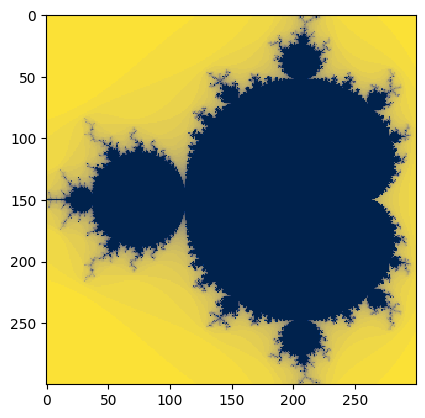

In [8]:
data_numba = [[mandel_numba(complex(x, y)) for x in xs] for y in ys]
plt.imshow(data_numba, interpolation="none")

## Parallelised numba implementation

Similarly to `numpy`, `numba` has optimisations related to parallelisation.
Let's see whether we can improve on the performance of `numpy_cython_1`, the best Cython solution we found earlier.
If we are certain that there are no dependencies between different elements in a range, we can parallelize iteration by using the `prange` function.

In [9]:
from numba import prange


@njit(parallel=True)
def mandel_numba_parallel(position, limit=50):
    xlim = position.shape[1]
    ylim = position.shape[0]
    diverged_at = np.zeros((ylim, xlim))
    for x in prange(xlim):
        for y in prange(ylim):
            steps = limit
            value = position[y, x]
            pos = position[y, x]
            while abs(value) < 2 and steps >= 0:
                steps -= 1
                value = value**2 + pos
            diverged_at[y, x] = steps

    return diverged_at

In [10]:
ymatrix, xmatrix = np.mgrid[ymin:ymax:ystep, xmin:xmax:xstep]
values = xmatrix + 1j * ymatrix

In [11]:
# Pure Python
%timeit data_python = [mandel(value) for row in values for value in row]

728 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Parallelised numba
%timeit data_numba_parallel = mandel_numba_parallel(values)

23.9 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is approximately a **300x speed up** without ever needing non-Python syntax. This shows how powerful `numba` can be!

To wrap this up this section on optimisation, let's demonstrate the the parallelised numba implementation generates the same figure as the pure-Python implementation.

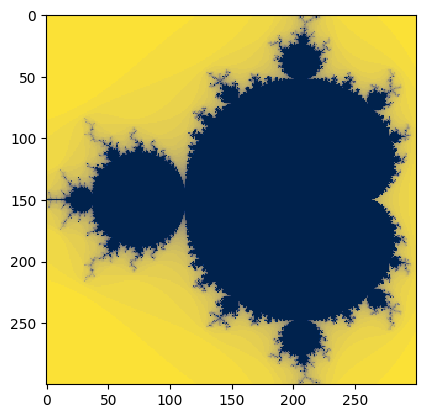

In [13]:
data_numba_parallel = mandel_numba_parallel(values)
plt.imshow(data_numba_parallel, interpolation="none")